In [2]:
!python -m spacy download pt_core_news_sm
!pip install googletrans==4.0.0-rc1
!pip install enelvo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 106.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.2 MB/s eta 0

In [3]:
from google.colab import drive
from googletrans import Translator
from enelvo.normaliser import Normaliser
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Concatenate, Input, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from unittest.mock import patch, MagicMock
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import unittest
import numpy as np
import pandas as pd
import spacy
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


# Pré-processamento

## 0) Base de Dados

In [5]:
norm = Normaliser(tokenizer='readable')
chats_clients = pd.read_csv('/content/drive/Shareddrives/grupo3moshi/augmented_data.csv')
chats_clients.head()

,No,Intencao,Pergunta,Resposta
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...


In [6]:
chats_clients.fillna('erro ao processar a pergunta', inplace=True)

In [7]:
nlp_pt = spacy.load("pt_core_news_sm")

In [8]:
def correct_grammar(text):
  return norm.normalise(text)

## 1) Word2Vec

O processo de Word2Vec é uma técnica de aprendizado de máquina com o objetivo de vetorizar palavras almejando preservar o contexto, convertendo o resultado para a forma numérica, para que os dados possam ser utilizados em modelos de aprendizado de máquina.

O Word2Vec pode possuir 2 arquiteturas, sendo elas:

- Skip-Gram: rede tenta prever as palavras de contexto ao redor de uma palavra central
- CBOW: rede tenta prever a palavra central com base no contexto ao redor da palavra central.

Para fins de comparação, ambas as técnicas serão abordadas no código a seguir:

### 1.1) Skip-Gram

In [9]:
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Tokenizando as colunas
chats_clients['Pergunta_tokens'] = chats_clients['Pergunta'].apply(lambda x: word_tokenize(x.lower()))
chats_clients['Resposta_tokens'] = chats_clients['Resposta'].apply(lambda x: word_tokenize(x.lower()))

# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_skip = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model = Word2Vec(sentences_skip, vector_size=100, window=5, min_count=1, sg=1)  #sg=1 para Skip-Gram

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### 1.2) Resultados Obtidos

In [10]:
# Acessando o vetor de uma palavra
vector_dia_skip = model.wv['dia']
print(vector_dia_skip)

[-0.26775223  0.57817674  0.06501746 -0.13198577 -0.0162866  -0.32053125
  0.68438333  0.02528406  0.15984471 -0.32278043  0.32283416 -0.5931242
  0.06256542 -0.15231565 -0.2381931   0.09556933  0.24559233 -0.1132349
  0.04261449 -0.1440163   0.17213431  0.03537409  0.17124328 -0.21593758
 -0.29399896  0.12060051 -0.13703685 -0.22065623  0.0543394  -0.22999065
  0.06246226  0.06420431  0.108389   -0.14155447 -0.07793944  0.1400825
  0.1490279  -0.24472725 -0.19108564 -0.09812341  0.07075102 -0.23465297
  0.08284451 -0.01925384  0.22655074  0.16606456 -0.0963831  -0.2707253
  0.04866063  0.16221946  0.27889755 -0.09459215  0.11571394 -0.03533408
 -0.35641074  0.06761176  0.31410757  0.25331837 -0.2050648   0.06803828
 -0.06043484 -0.19163443 -0.08034967  0.06921001 -0.09022131 -0.14438403
 -0.00162768  0.20808731 -0.08048407  0.13784875 -0.22473896 -0.00135946
  0.49609652  0.3445016   0.11022658  0.1330405   0.11327435 -0.3005817
 -0.02235943  0.12610886 -0.3561463  -0.0026406  -0.2110

In [11]:
# Encontrando palavras similares
similar_words_dia_skip = model.wv.most_similar('dia')
print(similar_words_dia_skip)

[('plantão', 0.7513531446456909), ('bom', 0.7505833506584167), ('especial', 0.7449821829795837), ('defense', 0.7284111976623535), ('intelligence', 0.714687168598175), ('processaremos', 0.707280158996582), ('agency', 0.6925069689750671), ('!', 0.6921923756599426), ('895', 0.6828874945640564), ('sobreminhs', 0.680862307548523)]


In [12]:
# Encontrando palavras similares
similar_words_bom_skip = model.wv.most_similar('bom')
print(similar_words_bom_skip)

[('!', 0.8151847124099731), ('dia', 0.750583291053772), ('processaremos', 0.7479262351989746), ('defense', 0.7417274713516235), ('intelligence', 0.740342915058136), ('conforme', 0.7381069660186768), ('agency', 0.7281288504600525), ('plantão', 0.7169572114944458), ('895', 0.7113294005393982), ('mais', 0.706836462020874)]


In [13]:
# Encontrando palavras similares
similar_words_dinheiro_skip = model.wv.most_similar('dinheiro')
print(similar_words_dinheiro_skip)

[('enviam', 0.8854102492332458), ('japão', 0.8706771731376648), ('poder', 0.8378614783287048), ('mary', 0.8298928141593933), ('st.', 0.8277102708816528), ('lá', 0.8219535946846008), ('pro', 0.815409779548645), ('bethlehem', 0.8146581053733826), ('tempo', 0.8084879517555237), ('cair', 0.8064796328544617)]


In [14]:
# Encontrando palavras similares
similar_words_pix_skip = model.wv.most_similar('pix')
print(similar_words_pix_skip)

[('sendo', 0.9741376638412476), ('via', 0.9667537808418274), ('realizadas', 0.9615600109100342), ('feitos', 0.9533548355102539), ('pagamentos', 0.9445545077323914), ('maioria', 0.9413060545921326), ('estão', 0.9315557479858398), ('pagas', 0.9166324734687805), ('são', 0.89717698097229), ('chegam', 0.8955625295639038)]


### 2.1) CBOW

In [15]:
# Unindo as listas de tokens de Pergunta e Resposta para o modelo processar a lista
sentences_CBOW = chats_clients['Pergunta_tokens'].tolist() + chats_clients['Resposta_tokens'].tolist()

# Utilizando o modelo Word2Vec
model_cbow = Word2Vec(sentences_CBOW, vector_size=100, window=5, min_count=1, sg=0)  #sg=0 para CBOW

### 2.2) Resultados Obtidos

In [16]:
# Acessando o vetor de uma palavra
vector_dia_cbow = model_cbow.wv['dia']
print(vector_dia_cbow)

[-6.06847167e-01  8.28706473e-02 -4.76075299e-02  8.57109651e-02
  2.46681094e-01 -4.91685450e-01  3.66922945e-01  6.53879762e-01
 -1.28465310e-01 -5.82987487e-01  2.34569222e-01 -1.01703560e+00
 -9.88721251e-02 -6.12462461e-02 -2.02412814e-01  1.89447358e-01
 -1.10763066e-01 -5.42182028e-01 -1.81206465e-02  9.14154872e-02
  6.41412616e-01  3.74433510e-02  3.30986500e-01 -1.53992087e-01
 -5.50062060e-01  2.86232442e-01 -3.57604623e-01  2.80812860e-01
 -1.44874021e-01 -2.84434617e-01  4.90425318e-01  1.20669223e-01
 -3.41862917e-01 -2.02008769e-01 -1.96157604e-01  2.79749066e-01
  1.15625568e-01 -6.57579482e-01 -2.15973154e-01 -4.45302576e-01
  5.97900823e-02 -1.95173174e-01 -9.58427861e-02 -2.62548655e-01
  2.60905921e-01  2.56988794e-01 -4.96952921e-01 -3.15416664e-01
  2.37095088e-01  8.64323881e-03  6.81344807e-01 -4.98351008e-01
  3.84730667e-01 -2.36044541e-01 -5.67693226e-02 -1.62179634e-01
  7.28925526e-01  3.40993345e-01 -4.64369595e-01 -3.51146832e-02
 -2.86561430e-01  6.06000

In [17]:
# Encontrando palavras similares
similar_words_dia_cbow = model_cbow.wv.most_similar('dia')
print(similar_words_dia_cbow)

[('bom', 0.9715335965156555), ('!', 0.9601024389266968), ('olá', 0.9576049447059631), ('noite', 0.9485138058662415), ('tarde', 0.9427953958511353), ('informar', 0.9411637783050537), ('feather', 0.9396428465843201), ('boa', 0.9349060654640198), ('uma', 0.9270160794258118), ('fiz', 0.9264461398124695)]


In [18]:
# Encontrando palavras similares
similar_words_bom_cbow = model_cbow.wv.most_similar('bom')
print(similar_words_bom_cbow)

[('dia', 0.9715335369110107), ('!', 0.9632455110549927), ('feather', 0.9556039571762085), ('olá', 0.9552845358848572), ('informar', 0.9525298476219177), ('noite', 0.9522715210914612), ('tarde', 0.9466104507446289), ('boa', 0.9453170299530029), ('uma', 0.9405238628387451), ('td', 0.9348506927490234)]


In [19]:
# Encontrando palavras similares
similar_words_dinheiro_cbow = model_cbow.wv.most_similar('dinheiro')
print(similar_words_dinheiro_cbow)

[('japão', 0.9941738247871399), ('enviar', 0.983680784702301), ('?', 0.9768919348716736), ('tempo', 0.9711207151412964), ('8', 0.96629798412323), ('exatamente', 0.9651689529418945), ('lado', 0.9641366004943848), ('levará', 0.9629144668579102), ('verso', 0.9608359336853027), ('fotos', 0.9599601030349731)]


In [20]:
# Encontrando palavras similares
similar_words_pix_cbow = model_cbow.wv.most_similar('pix')
print(similar_words_pix_cbow)

[('via', 0.9911543130874634), ('pagamentos', 0.9672412276268005), ('feitos', 0.9600024819374084), ('sendo', 0.9509522914886475), ('realizadas', 0.9395662546157837), ('estão', 0.9393516182899475), ('pagas', 0.8824478387832642), ('apta', 0.8639152646064758), ('chegam', 0.8555289506912231), ('maioria', 0.8426751494407654)]


### 3.1) Word Embedding


Dessa forma, é fundamental gerar os embedding das colunas para que futuros modelos de aprendizado de máquina possam compreender e utilizar os dados de cada frase. Para tal, será utilizado uma média dos vetores de cada frase, desenvolvido a seguir, utilizando a abordagem CBOW (padrão):


In [21]:
import numpy as np

# Função para gerar o embedding médio de uma frase
def get_sentence_embedding(tokens, model):
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

### 3.2) Resultados Obtidos

In [22]:
# Aplicando a função para gerar os embeddings e salvando nas novas colunas
chats_clients['Pergunta_embedding'] = chats_clients['Pergunta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))
chats_clients['Resposta_embedding'] = chats_clients['Resposta_tokens'].apply(lambda tokens: get_sentence_embedding(tokens, model_cbow))

In [23]:
chats_clients['Pergunta_embedding'].head()

,Pergunta_embedding
0,"[-0.5339272, 0.09688279, -0.10819608, 0.036006..."
1,"[-0.90104055, 0.0896402, -0.17322218, 0.082651..."
2,"[-0.7726842, 0.11069913, -0.2013543, 0.0921977..."
3,"[-0.5158322, 0.045972086, -0.11637107, 0.04882..."
4,"[-0.47279325, 0.2090434, -0.16846703, 0.066044..."


In [24]:
chats_clients['Resposta_embedding'].head()

,Resposta_embedding
0,"[-0.49377516, 0.0997112, -0.11359496, 0.042352..."
1,"[-0.39972177, 0.700471, -0.4117935, 0.19998248..."
2,"[-0.47853816, 0.21461147, -0.09644883, 0.11503..."
3,"[-0.50345904, 0.26137555, -0.16315313, 0.00219..."
4,"[-0.50345904, 0.26137555, -0.16315313, 0.00219..."


## 2) Base de Dados Final

In [25]:
chats_clients

,No,Intencao,Pergunta,Resposta,Pergunta_tokens,Resposta_tokens,Pergunta_embedding,Resposta_embedding
0,1,Como depositar,Boa dia.tudo bem?eu gostaria de saber sobre aq...,"Bom dia! Sim, o sr pode utilizar o cartão de d...","[boa, dia.tudo, bem, ?, eu, gostaria, de, sabe...","[bom, dia, !, sim, ,, o, sr, pode, utilizar, o...","[-0.5339272, 0.09688279, -0.10819608, 0.036006...","[-0.49377516, 0.0997112, -0.11359496, 0.042352..."
1,2,Como fazer remessa,Como enviar dinheiro do Japão?,"Para se inscrever no serviço de remessa, por f...","[como, enviar, dinheiro, do, japão, ?]","[para, se, inscrever, no, serviço, de, remessa...","[-0.90104055, 0.0896402, -0.17322218, 0.082651...","[-0.39972177, 0.700471, -0.4117935, 0.19998248..."
2,3,Tempo de remessa,Quanto tempo levará para o beneficiário recebe...,"Via de regra, as remessas serão pagas via PIX ...","[quanto, tempo, levará, para, o, beneficiário,...","[via, de, regra, ,, as, remessas, serão, pagas...","[-0.7726842, 0.11069913, -0.2013543, 0.0921977...","[-0.47853816, 0.21461147, -0.09644883, 0.11503..."
3,4,"Pedido de envio via metodo ""ByPhone""",Boa tarde\nAcabei de fazer a transferência de ...,iremos processar a sua solicitacao.\nMuito obr...,"[boa, tarde, acabei, de, fazer, a, transferênc...","[iremos, processar, a, sua, solicitacao, ., mu...","[-0.5158322, 0.045972086, -0.11637107, 0.04882...","[-0.50345904, 0.26137555, -0.16315313, 0.00219..."
4,5,"Pedido de envio via metodo ""ByPhone""",Poderia fazer a remessa de 22yenes para o BBB ...,iremos processar a sua solicitacao.\nMuito obr...,"[poderia, fazer, a, remessa, de, 22yenes, para...","[iremos, processar, a, sua, solicitacao, ., mu...","[-0.47279325, 0.2090434, -0.16846703, 0.066044...","[-0.50345904, 0.26137555, -0.16315313, 0.00219..."
...,...,...,...,...,...,...,...,...
1510,501,Atualizacao de dados cadastrais,feather boa tarde como faço para fazer ampere ...,antiophthalmic factor senhora pode trocar pelo...,"[feather, boa, tarde, como, faço, para, fazer,...","[antiophthalmic, factor, senhora, pode, trocar...","[-0.5804344, 0.06237927, -0.13470794, 0.057049...","[-0.8606049, 0.14268234, -0.04298023, -0.25235..."
1511,502,Tempo de entrega do cartao,Bom dia Consegui fazer depósito sem o cartão q...,Boa noite group O sr solicitou dia 28. Será en...,"[bom, dia, consegui, fazer, depósito, sem, o, ...","[boa, noite, group, o, sr, solicitou, dia, 28....","[-0.5630415, 0.08684154, -0.1317246, 0.0167596...","[-0.53960323, 0.048282325, -0.07961207, -0.024..."
1512,503,Cancelamento,"Boa noite,a beneficiária me avisou que a conta...","Sim, podemos cancelar o valor voltará No seu s...","[boa, noite, ,, a, beneficiária, me, avisou, q...","[sim, ,, podemos, cancelar, o, valor, voltará,...","[-0.5315998, 0.17506938, -0.13843985, 0.057225...","[-0.54635626, 0.17236519, -0.16412811, 0.09573..."
1513,504,Reembolso,"boa noite Eu fiz um depósito errado, era pra d...",É possível solicitar o reembolso diretamente d...,"[boa, noite, eu, fiz, um, depósito, errado, ,,...","[é, possível, solicitar, o, reembolso, diretam...","[-0.68798053, 0.090044096, -0.1304638, 0.00468...","[-0.6921064, 0.15981163, -0.113951534, -0.0557..."


### Classificador de intenção

O classificador de intenção é um sistema que identifica a intenção por trás de uma mensagem de texto, neste caso, seria as mensagens (entradas do chatbot) enviadas pelos clientes. A intenção refere-se ao que o usuário deseja realizar, como transferir dinheiro, taxa de câmbio, etc.
Nesta seção é abordado o treinamento do modelo com suas respectivas métricas (Acurácia, Recall, F1-Score).

Abaixo há uma classe de callback que guarda as métricas de F1-Score e recall. A F1-score é uma métrica que leva em consideração a precisão e o recall, sendo definida pela seguinte fórmula:
$$ F1-Score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

F1 é conhecido como a média harmônica da precisão e do recall. A pontuação F1 se torna 1 apenas se a precisão e recall são 1. Se a precisão e o recall são altos, logo o valor de F1 também é alta.

a métrica Recall (sensibilidade) ajuda a avaliar a capacidade do modelo de identificar corretamente todos os exemplos positivos de uma classe. Por exemplo, se temos um problema onde devemos classificar com uma classificação "sim" ou "não" referente a spam de e-mails, o recall nesse caso nos dirá quantos e-mails de spam o modelo conseguiu identificar corretamente, dentre todos os e-mails que realmente eram spam.

A fórmula do recall é a seguinte:

$$ Recall = \frac{TP}{TP + FN}$$

Já a acurácia é a proporção total de exemplos que o modelo classificou corretamente, ou seja, o quanto o modelo conseguiu acertar. Fórmula:


$$ Recall = \frac{Previsões corretas}{Previsões incorretas}$$

In [26]:
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.validation_data
        val_pred = np.argmax(self.model.predict(val_data), axis=1)
        val_f1 = f1_score(val_labels, val_pred, average='macro')
        recall = recall_score(val_labels, val_pred, average='macro', zero_division=1)
        print(f'Epoch {epoch + 1}: f1-score: {val_f1:.4f} - recall: {recall:.4f}')
        logs['f1_score'] = val_f1
        logs['recall'] = recall

In [27]:
class IntentClassifier:
    def __init__(self, epochs=180, batch_size=16, test_size=0.4, validation_split=0.4, learning_rate=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.test_size = test_size
        self.validation_split = validation_split
        self.learning_rate = learning_rate
        self.model = None
        self.label_encoder = None

    def prepare_data(self, chats_clients):
        answer_embeddings = np.array(chats_clients['Pergunta_embedding'].tolist())
        response_embeddings = np.array(chats_clients['Resposta_embedding'].tolist())

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(chats_clients['Intencao'])

        combined_embeddings = np.stack((answer_embeddings, response_embeddings), axis=1)
        X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, self.labels, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def build_model(self, input_shape):
        self.model = Sequential()
        self.model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        self.model.add(Dropout(0.5))
        self.model.add(LSTM(64))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dense(32, activation='relu'))
        self.model.add(Dense(len(np.unique(self.labels)), activation='softmax'))
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train(self, X_train, X_test, y_train, y_test):
        model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

        # Callback do F1-Score e recall
        metrics_callback = MetricsCallback(validation_data=(X_test, y_test))

        history = self.model.fit(X_train, y_train, epochs=self.epochs,
                       batch_size=self.batch_size,
                       validation_split=self.validation_split,
                       callbacks=[
                           model_checkpoint,
                           metrics_callback
                           ])

        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

        return history

    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)

        return y_pred_classes

    def generate_report(self, y_test, y_pred_classes):
      print(len(y_test))
      print(classification_report(y_test, y_pred_classes))

In [28]:
classifier = IntentClassifier()
X_train, X_test, y_train, y_test = classifier.prepare_data(chats_clients)
classifier.build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
classifier.train(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 2, 256)              │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 18)                  │             594 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,506 (1.23 MB)

 Trainable params: 323,506 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/180
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Epoch 1: f1-score: 0.0772 - recall: 0.1084
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.2258 - loss: 2.7907 - val_accuracy: 0.3159 - val_loss: 2.4887 - f1_score: 0.0772 - recall: 0.1084
Epoch 2/180
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 2: f1-score: 0.1107 - recall: 0.1623
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3463 - loss: 2.3857 - val_accuracy: 0.4505 - val_loss: 1.9801 - f1_score: 0.1107 - recall: 0.1623
Epoch 3/180
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 3: f1-score: 0.1230 - recall: 0.1659
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4731 - loss: 1.9890 - val_accuracy: 0.4478 - val_loss: 1.8515 - f1_score: 0.1230 - recall: 0.1659
Epoch 4/180
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 4: f1-score: 0.1135 - recall: 0.1671
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4592 - loss: 1.9131 - val_accuracy: 0.4643 - val_loss: 1.7742 - f1_score: 0.1135 - recall: 0.1671
Epoch 5/180


### Matriz de Confusão

A matriz de confusão avalia o desempenho do modelo. Os eixos Y representa as classes verdadeiras (true label) e o eixo x representa as classes previstas (predicted label). Além de indicar a frequência, as cores na matriz representam a intensidade dos valores nas células, ajudando a visualizar a frequência das classificações corretas e incorretas. Quanto mais escuro, mais frequente.

Cada célula na matriz indica o número de vezes que uma classe verdadeira foi prevista como classe específica. Já as células da diagonal principal indicam as instâncias onde o modelo previu corretamente.

#### Interpretação
* A célula (7, 7) tem 137 instâncias, indicando que 137 exemplos da classe 7 foram corretamente classificados como classe 7. Parece ser a classe mais corretamente classificada, com 142 instâncias corretas e poucas confusões com outras classes.

* A célula (11, 11) tem 68 instâncias, indicando que 68 exemplos da classe 11 foram corretamente classificados como classe 11.

* A célula (12, 3) mostra que 3 exemplos da classe 12 foram incorretamente classificados como classe 3.

* A célula (10, 12) mostra que 2 exemplos da classe 10 foram incorretamente classificados como classe 12.

É observado que a classe de índice 12, 16 e 10 mostra uma confusão e que o modelo trabalha bem com as classes 7 e 11. Conclui-se então que as células ao longo da diagonal principal indicam as instâncias onde o modelo previu corretamente a classe e por este motivo se destaca na matriz.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


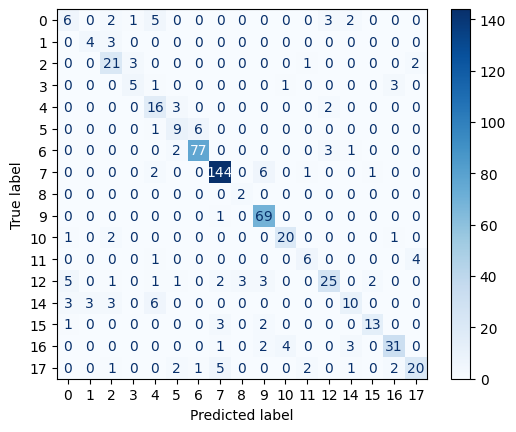

606
              precision    recall  f1-score   support

           0       0.38      0.32      0.34        19
           1       0.57      0.57      0.57         7
           2       0.64      0.78      0.70        27
           3       0.56      0.50      0.53        10
           4       0.48      0.76      0.59        21
           5       0.53      0.56      0.55        16
           6       0.92      0.93      0.92        83
           7       0.92      0.94      0.93       154
           8       0.40      1.00      0.57         2
           9       0.84      0.99      0.91        70
          10       0.80      0.83      0.82        24
          11       0.60      0.55      0.57        11
          12       0.76      0.58      0.66        43
          14       0.59      0.40      0.48        25
          15       0.81      0.68      0.74        19
          16       0.84      0.76      0.79        41
          17       0.77      0.59      0.67        34

    accuracy          

In [29]:
y_pred_classes = classifier.predict(X_test)

# Calcula a matriz de confusão
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_classes, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

classifier.generate_report(y_test, y_pred_classes)

## Testes

Nesta seção, é abordado os testes unitários que simulam o modelo. O objetivo é verificar se a função de vetorização e se o treinamento do classificador funcionam corretamente.

**fit**: Simula o comportamento do método fit do Keras, que é responsável por treinar a rede neural. Um histórico genérico e simulado é criado com valores de loss (perda), accuracy (acurácia), val_loss (perda na validação) e val_accuracy (acurácia na validação).

**evaluate**: Simula a avaliação do modelo, retornando uma perda de 0.3 e uma acurácia de 0.9.

**predict**: Simula a previsão do modelo, retornando probabilidades associadas às classes.

* Verificações:
  * Se o histórico de treino não é None.
  * Se o histórico contém registros de perda (loss).
  * Garante que os valores de perda não sejam NaN.
  * Comparação dos valores simulados de loss e accuracy retornados pela função evaluate.

* Teste da função de previsão (test_predict_function)
  * Objetivo: garantir que a função de previsão funcione corretamente após o treinamento.
  * Execução: a função train é chamada para treinar o modelo, seguida pela execução da função predict.
  * Verificações:
    Verifica se o número de previsões (y_pred_classes) corresponde ao número de amostras de teste (y_test).

* Teste com dados inválidos (test_invalid_data)
  * Objetivo: testar o funcionamento da função de treinamento quando tiver dados inválidos.
  * Execução: chamar a função train com arrays vazios para os dados de entrada e saída.
  * Verificação:
verificar se o ValueError é levantado quando os dados de treino são inválidos.

### Teste da Função de vetorização

In [30]:
def get_vector(model, word):
    try:
        return model.wv[word]
    except KeyError:
        return None  # Retorna None se a palavra não estiver no vocabulário

In [31]:
class TestWord2Vec(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        # Carregar o modelo Word2Vec apenas uma vez para todos os testes
        cls.model = model  # Supondo que o modelo já foi carregado em `model`

    def test_get_word_vector_present(self):
        word = 'dia'
        vector = get_vector(self.model, word)
        self.assertIsNotNone(vector, "O vetor para uma palavra presente deve ser diferente de None.")
        self.assertEqual(len(vector), 100, "O vetor deve ter 100 dimensões.")

    def test_get_no_word_vector(self):
        word = 'palavraInexistente'
        vector = get_vector(self.model, word)
        self.assertIsNone(vector, "O vetor para uma palavra ausente deve ser None.")

    def test_obter_vetor_input_invalido(self):
        word = 12345  # Um número em vez de uma string
        vector = get_vector(self.model, word)
        self.assertIsNone(vector, "O vetor para uma entrada inválida deve ser None.")

    def test_vetor_tamanho(self):
        word = 'bom'
        vector = get_vector(self.model, word)
        self.assertEqual(len(vector), 100, "O vetor deve ter 100 dimensões.")


### Teste do classificador de intenções

In [32]:
class TestIntentClassifier(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        # Instanciando a classe `IntentClassifier`
        cls.classifier = IntentClassifier(epochs=20, batch_size=2)

        # Gerando dados fictícios para teste
        np.random.seed(42)
        cls.X_train = np.random.rand(10, 2, 300)  # samples, embeddings por sample, dimensão
        cls.y_train = np.random.randint(0, 3, size=(10,))  # 3 classes
        cls.X_test = np.random.rand(4, 2, 300)  # 4 samples de teste
        cls.y_test = np.random.randint(0, 3, size=(4,))

        # Simulação dos dados de `self.labels`
        cls.classifier.labels = cls.y_train  # Definição dos labels
        cls.classifier.build_model(input_shape=(2, 300))

    @patch('tensorflow.keras.Model.fit')
    @patch('tensorflow.keras.Model.evaluate')
    @patch('tensorflow.keras.Model.predict')
    def test_train_function(self, mock_predict, mock_evaluate, mock_fit):
        # Mockagem do método `fit` de treino
        mock_history = MagicMock()
        mock_history.history = {
            'loss': [0.5, 0.4, 0.3],
            'accuracy': [0.7, 0.8, 0.9],
            'val_loss': [0.6, 0.5, 0.4],
            'val_accuracy': [0.6, 0.7, 0.8]
        }
        mock_fit.return_value = mock_history

        # Mockagem do evaluate
        mock_evaluate.return_value = (0.3, 0.9)  # loss, accuracy

        # Mockagem do método`predict`
        mock_predict.return_value = np.array([[0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.1, 0.9]])

        history = self.classifier.train(self.X_train, self.X_test, self.y_train, self.y_test)

        # Verificações
        self.assertIsNotNone(history, "O histórico de treino não pode ser None")
        self.assertTrue(len(history.history['loss']) > 0, "Deve ter logs de perda no histórico")
        self.assertFalse(any(np.isnan(history.history['loss'])), "O valor de perda não deve ser NaN")
        self.assertEqual(mock_evaluate.return_value[0], 0.3, "O loss deve ser 0.3")
        self.assertEqual(mock_evaluate.return_value[1], 0.9, "A acurácia deve ser 0.9")

    def test_predict_function(self):
        # Teste da previsão após o treinamento
        self.classifier.train(self.X_train, self.X_test, self.y_train, self.y_test)
        y_pred_classes = self.classifier.predict(self.X_test)
        self.assertEqual(len(y_pred_classes), len(self.y_test), "O número de previsões deve ser igual ao número de testes")

    def test_invalid_data(self):
        # Teste com dados inválidos
        with self.assertRaises(ValueError):
            self.classifier.train(np.array([]), np.array([]), np.array([]), np.array([]))

In [33]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 2, 256)              │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 527,778 (2.01 MB)

 Trainable params: 527,778 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

.

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Epoch 1: f1-score: 0.2222 - recall: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - accuracy: 0.3125 - loss: nan - val_accuracy: 0.5000 - val_loss: nan - f1_score: 0.2222 - recall: 0.3333
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 2: f1-score: 0.2222 - recall: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7083 - loss: nan - val_accuracy: 0.5000 - val_loss: nan - f1_score: 0.2222 - recall: 0.3333
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 3: f1-score: 0.2222 - recall: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5833 - loss: nan - val_accuracy: 0.5000 - val_loss: nan - f1_score: 0.2222 - recall: 0.3333
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 4: f1-score: 0.2222 - recall: 0.3333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6458 - loss: nan - val_accuracy: 0.5000 - val_loss: nan - f1_score: 0.2222 - recall: 0.3333
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch

......
----------------------------------------------------------------------
Ran 7 tests in 6.946s

OK


Test Loss: 0.3, Test Accuracy: 0.9
